Stein VI ideally combines scalability of variational inference with flexibility of non parametric posterior densities.  A good test case is one with a multi-modal posterior. 

In [2]:
%pylab inline

import numpy as np
import numpyro
import jax
import jax.numpy as jnp
import vbjax
numpyro.set_host_device_count(8)
import arviz as az

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## Curve fitting Jansen Rit

Let's take a look at the Jansen Rit model, just to do some curve fitting.

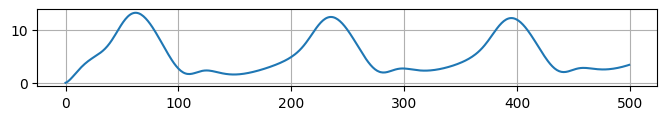

In [4]:
def make_curve():
    dt = 1
    ts = np.r_[:500]
    _, loop = vbjax.make_ode(dt, lambda x, p: vbjax.jr_dfun(x, 0, p))
    def curve(x0,p):
        xs = loop(x0, ts, p)
        v = xs[:, 1] - xs[:, 2]
        return np.clip(v,-60,60)  # avoid numerical problems
    return curve

curve = make_curve()
x0 = np.zeros(6)
p = vbjax.jr_default_theta
x = curve(x0, p)
figure(figsize=(8, 1)); plot(x); grid(1)

for unstable parts of parameter space, it just flatlines:

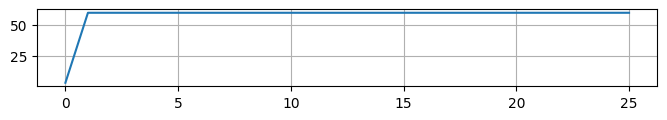

In [5]:
ph = vbjax.jr_default_theta._replace(a=8)
figure(figsize=(8, 1)); plot(curve(x0, ph)); grid(1)

## MCMC initial conditions only

We can then write out detailed Bayesian model with priors, such that we infer the initial conditions of the curve generated:

In [6]:
def model1(x=None):
    from numpyro import sample
    from numpyro.distributions import Normal as N
    x0h = sample('x0h', N(np.zeros(6), 1).to_event(1))
    xh_mu = curve(x0h, p)
    sample('xh', N(xh_mu, 1).to_event(1), obs=x)

Let's run that with several MCMC chains,

In [7]:
nuts_kernel = numpyro.infer.NUTS(model1)
mcmc = numpyro.infer.MCMC(nuts_kernel, num_chains=4, num_warmup=500, num_samples=500)
key = jax.random.PRNGKey(0)
mcmc.run(key, x=x)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/1000 [00:00<?, ?it/s]

In [8]:
inf_data = az.from_numpyro(mcmc)
az.summary(inf_data)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x0h[0],-0.517,0.366,-1.133,-0.036,0.143,0.117,8.0,11.0,1.51
x0h[1],-0.578,0.937,-2.012,0.836,0.344,0.300,8.0,22.0,1.47
x0h[2],0.244,0.677,-0.993,1.665,0.040,0.029,252.0,479.0,1.27
x0h[3],0.072,0.054,-0.000,0.150,0.020,0.015,8.0,51.0,1.44
x0h[4],0.010,0.638,-1.544,0.723,0.299,0.227,7.0,20.0,1.56
x0h[5],-0.034,0.421,-0.791,0.362,0.181,0.136,8.0,11.0,1.48


$\hat{R}$ looks ok, as do pair plots:

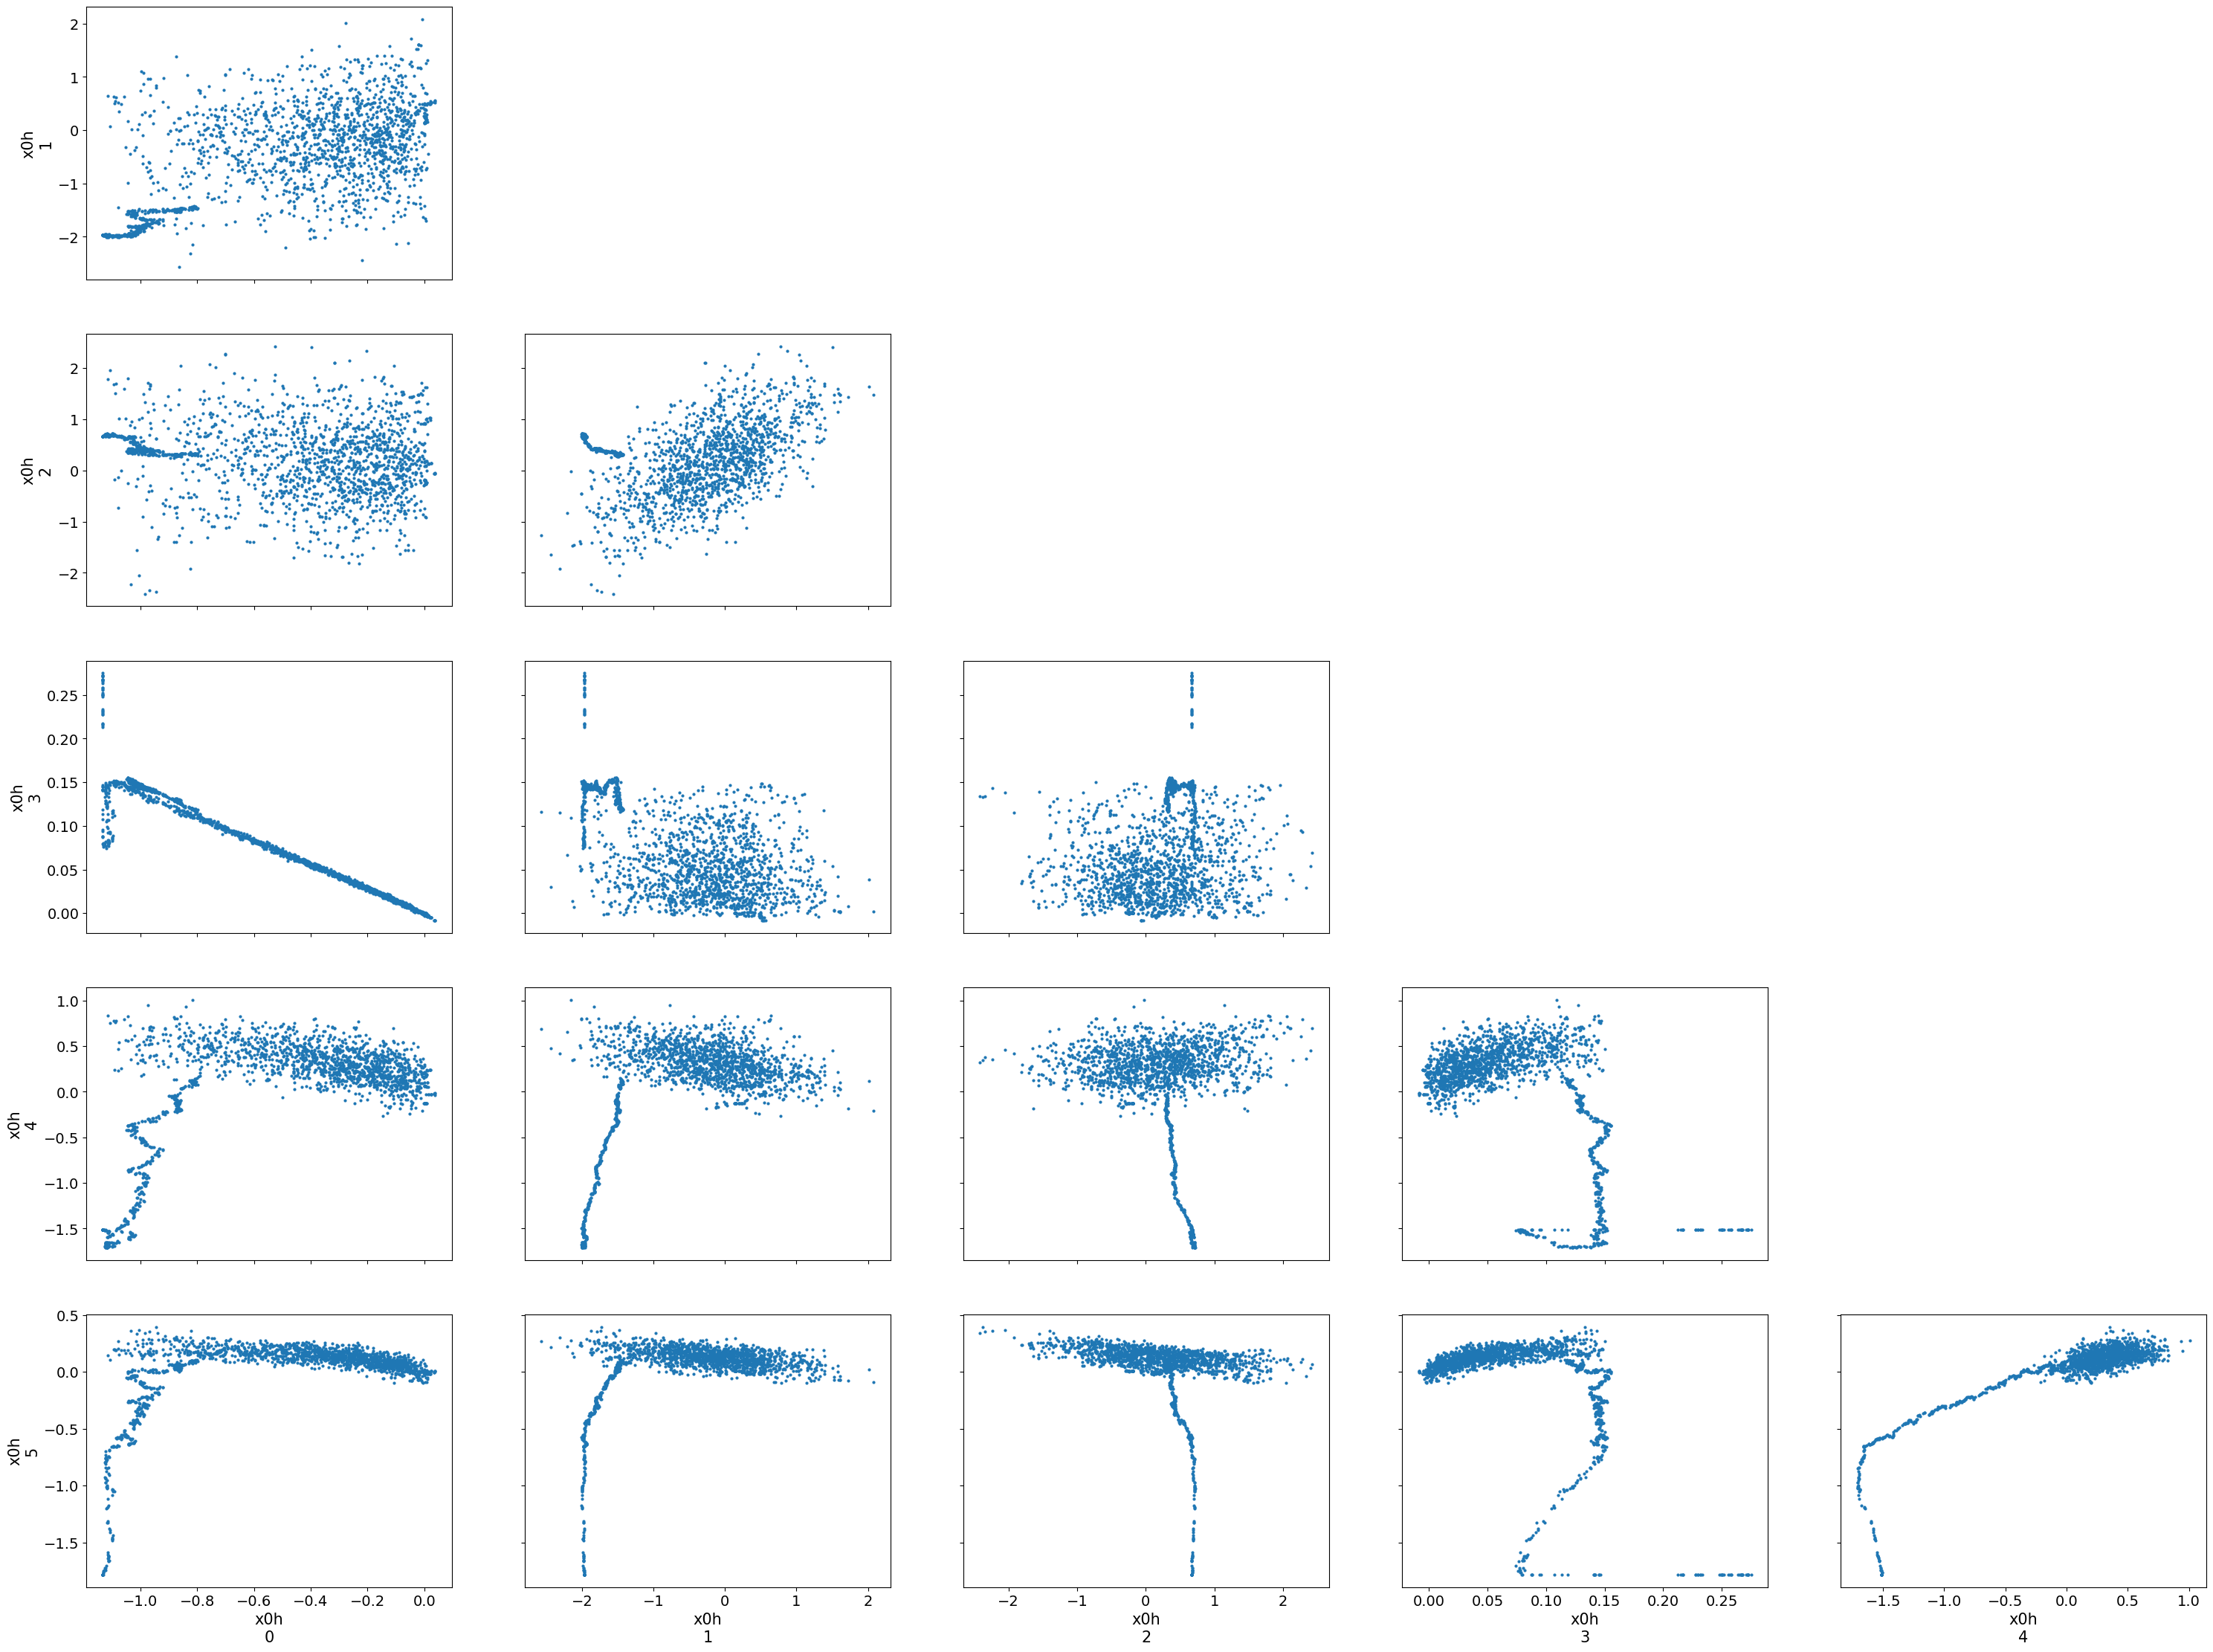

In [9]:
az.plot_pair(inf_data);

## Variational inference 

Let's try that with VI

In [10]:
guide1 = numpyro.infer.autoguide.AutoMultivariateNormal(model1)
svi = numpyro.infer.SVI(
    model1,
    guide1,
    numpyro.optim.Adam(step_size=1e-4),
    loss=numpyro.infer.Trace_ELBO()
)

result = svi.run(key, 2000, x)

100%|██████████████████████████████| 2000/2000 [00:00<00:00, 2006.11it/s, init loss: 57146.5117, avg. loss [1901-2000]: 34118.2656]


Once the approximate density is trained, we can sample from it using the `Predictive` construct,

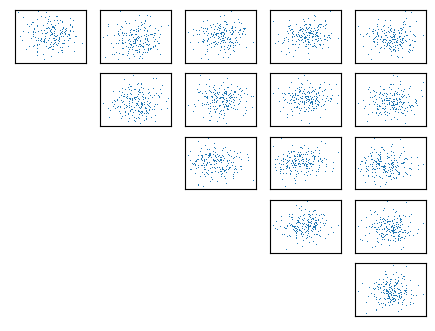

In [11]:
vi_pred = numpyro.infer.Predictive(guide1, params=result.params, num_samples=200)
vi_samp = vi_pred(key, x)

x0h = vi_samp['x0h']
for i in range(6):
    for j in range(6):
        if i < j:
            subplot(6,6,i*6+j+1)
            plot(x0h[:,i],x0h[:,j], ',')
            xticks([]); yticks([]);

Giving us a unimodal approximate posterior.

## MCMC all parameters

How about inferring all those JR parameters?

In [12]:
vbjax.jr_default_theta

JRTheta(A=3.25, B=22.0, a=0.1, b=0.05, v0=5.52, nu_max=0.0025, r=0.56, J=135.0, a_1=1.0, a_2=0.8, a_3=0.25, a_4=0.25, mu=0.22, I=0.0)

we can automate writing the code a bit,

In [13]:
for f in vbjax.JRTheta._fields:
    val = getattr(vbjax.jr_default_theta, f)
    half = val / 2
    print(f"{f}h = sample('{f}h', N({val}, {half}))")
    
parts = ', '.join([f'{f}h' for f in vbjax.JRTheta._fields])
print(f'ph = nfjax.JRTheta({parts})')

Ah = sample('Ah', N(3.25, 1.625))
Bh = sample('Bh', N(22.0, 11.0))
ah = sample('ah', N(0.1, 0.05))
bh = sample('bh', N(0.05, 0.025))
v0h = sample('v0h', N(5.52, 2.76))
nu_maxh = sample('nu_maxh', N(0.0025, 0.00125))
rh = sample('rh', N(0.56, 0.28))
Jh = sample('Jh', N(135.0, 67.5))
a_1h = sample('a_1h', N(1.0, 0.5))
a_2h = sample('a_2h', N(0.8, 0.4))
a_3h = sample('a_3h', N(0.25, 0.125))
a_4h = sample('a_4h', N(0.25, 0.125))
muh = sample('muh', N(0.22, 0.11))
Ih = sample('Ih', N(0.0, 0.0))
ph = nfjax.JRTheta(Ah, Bh, ah, bh, v0h, nu_maxh, rh, Jh, a_1h, a_2h, a_3h, a_4h, muh, Ih)


then paste that into a new model function, correcting `I` which is just 0 (not currently used in the model),

In [16]:
def model2(x=None):
    from numpyro import sample
    from numpyro.distributions import Normal as N
    
    Ah = sample('Ah', N(3.25, 1.625))
    Bh = sample('Bh', N(22.0, 11.0))
    ah = sample('ah', N(0.1, 0.05))
    bh = sample('bh', N(0.05, 0.025))
    v0h = sample('v0h', N(5.52, 2.76))
    nu_maxh = sample('nu_maxh', N(0.0025, 0.00125))
    rh = sample('rh', N(0.56, 0.28))
    Jh = sample('Jh', N(135.0, 67.5))
    a_1h = sample('a_1h', N(1.0, 0.5))
    a_2h = sample('a_2h', N(0.8, 0.4))
    a_3h = sample('a_3h', N(0.25, 0.125))
    a_4h = sample('a_4h', N(0.25, 0.125))
    muh = sample('muh', N(0.22, 0.11))
    Ih = 0.0
    ph = vbjax.JRTheta(Ah, Bh, ah, bh, v0h, nu_maxh, rh, Jh, a_1h, a_2h, a_3h, a_4h, muh, Ih)
    
    x0h = sample('x0h', N(np.zeros(6), 1))
    xh_mu = curve(x0h, ph)
    sample('xh', N(xh_mu, 1), obs=x)

run MCMC again, though because the problem is harder, add 3 improvements
- use dense metric
- 8 chains instead of 4
- more samples

In [17]:
nuts_kernel = numpyro.infer.NUTS(model2, dense_mass=True)
mcmc = numpyro.infer.MCMC(nuts_kernel, num_chains=8, 
                          num_warmup=2000, num_samples=2000)
key = jax.random.PRNGKey(0)
mcmc.run(key, x=x)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [20]:
inf_data = az.from_numpyro(mcmc)
az.summary(inf_data)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
Ah,-1.420,5.706,-8.864,10.503,2.006,1.473,9.0,12.0,3.83
Bh,5.862,13.578,-15.100,29.862,4.502,3.292,10.0,26.0,2.38
Jh,-15.671,118.371,-202.750,251.994,41.191,30.222,8.0,12.0,4.66
a_1h,0.688,0.883,0.002,2.648,0.307,0.226,8.0,14.0,4.54
a_2h,0.157,1.380,-2.827,1.973,0.483,0.354,9.0,22.0,3.61
a_3h,0.219,0.302,-0.276,0.900,0.105,0.077,9.0,23.0,3.73
a_4h,0.373,0.391,-0.298,1.048,0.134,0.098,9.0,11.0,3.86
ah,0.038,0.010,0.025,0.053,0.004,0.003,9.0,22.0,3.53
bh,0.057,0.025,0.024,0.112,0.009,0.006,9.0,25.0,3.29
muh,0.077,0.257,-0.260,0.536,0.089,0.065,9.0,22.0,3.78


Diagnostics are bad

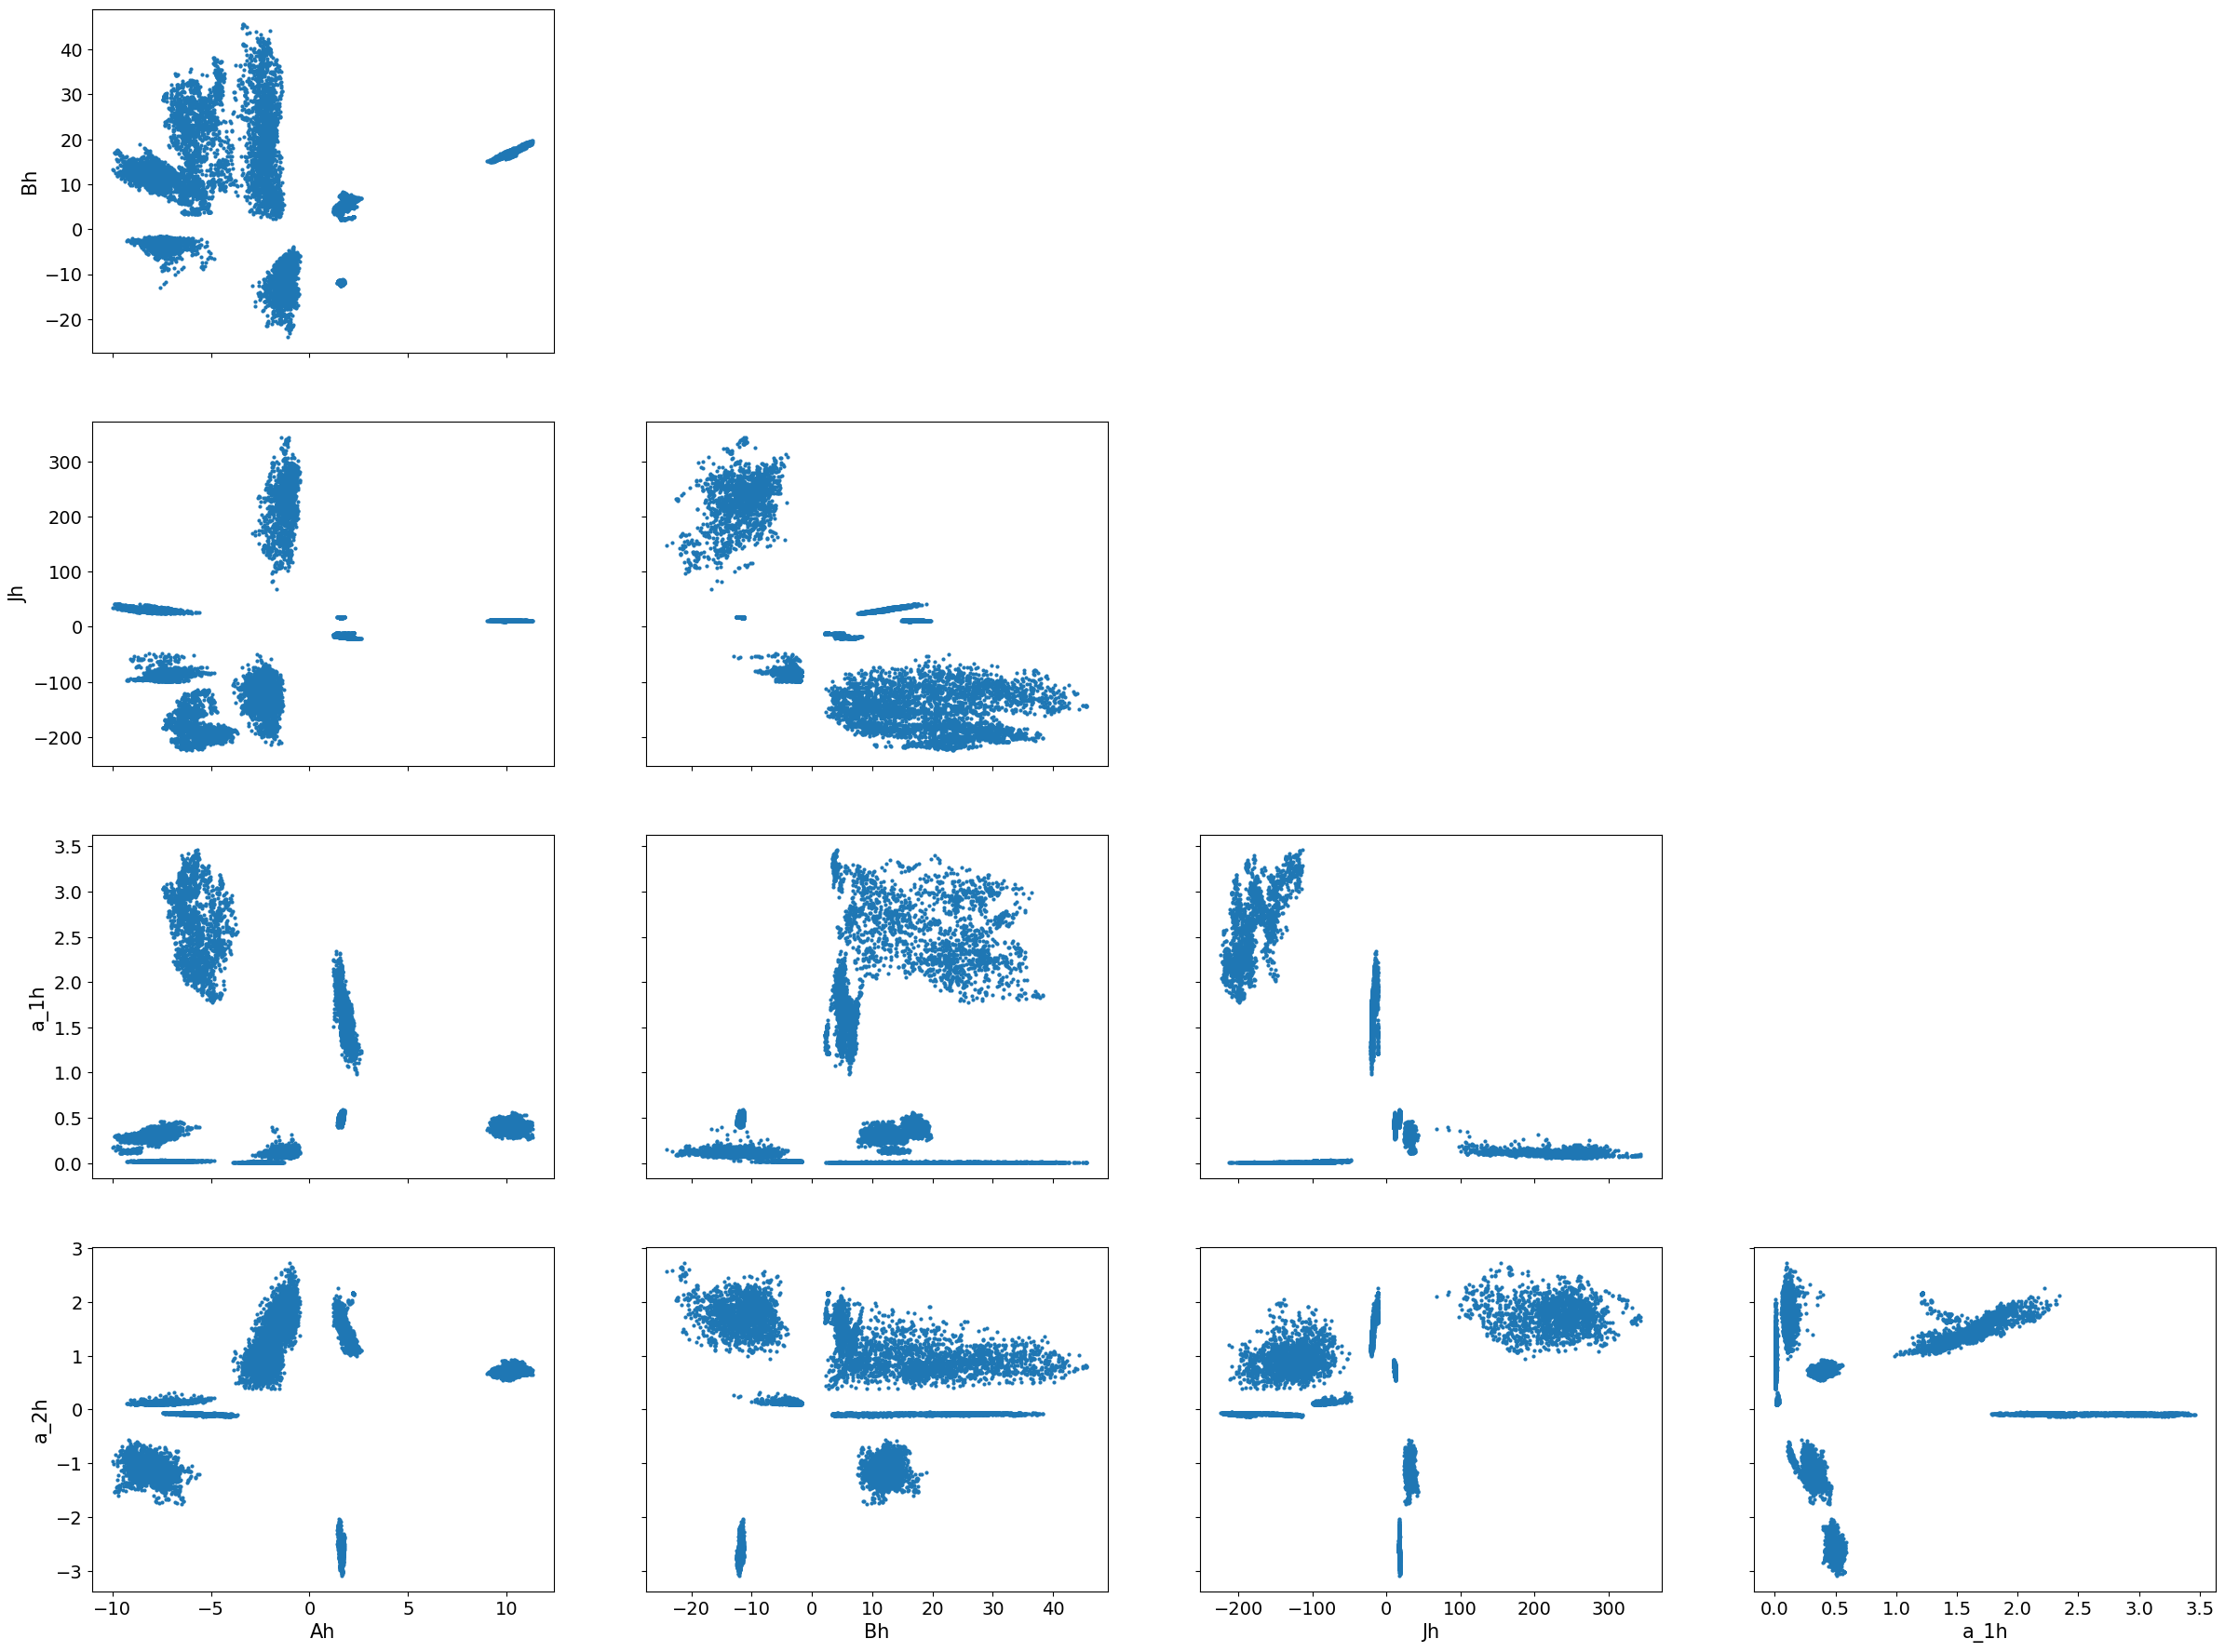

In [21]:
az.plot_pair(inf_data, var_names=['Ah', 'Bh', 'Jh', 'a_1h', 'a_2h']);

and pair plots suggest significant multimodality: the `a_2h` vs `Jh` plot shows 8 clusters; since we have 8 chains that means each chain got stuck in a different mode.  Then again, this model is quick to run, so if we run double the chains, we might have fully converged despite the multimodality.

## Variational inference

We already can tell that the standard mean field VI won't work because the posterior is multimodal.  But autoregressive flow-based approximate densities should work, so let's try that before going on to Stein VI:

In [23]:
def inits(args=None):
    if args is None:
        return inits
    if args['name'] in ph._fields:
        return getattr(ph, args['name'])
    if args['name'] == 'x0h':
        return jnp.zeros(6)
    if args['name'] == 'xh':
        return jnp.zeros_like(x)

inits.func = inits
    
guide2 = numpyro.infer.autoguide.AutoBNAFNormal(model2, init_loc_fn=inits, hidden_factors=[50, 50])
svi = numpyro.infer.SVI(
    model2,
    guide2,
    numpyro.optim.Adam(step_size=1e-9),
    loss=numpyro.infer.Trace_ELBO()
)

result = svi.run(key, 5, x)

100%|██████████████████████████████████████████████████████████| 5/5 [00:01<00:00,  2.61it/s, init loss: nan, avg. loss [5-5]: nan]


methodologically we should inspect variational results in terms of posterior samples as well

In [24]:
vi_pred = numpyro.infer.Predictive(guide2, params=result.params, num_samples=2000)
vi_samp = vi_pred(key, x)

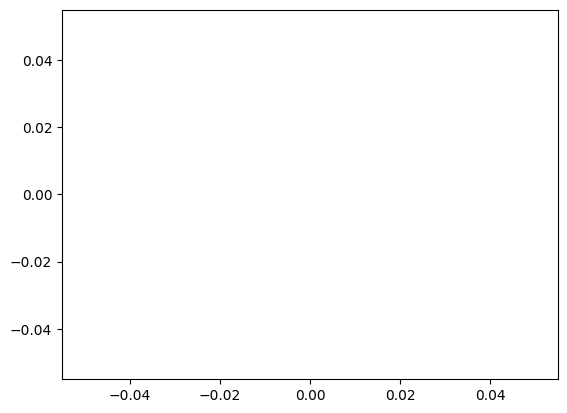

In [25]:
plot(vi_samp['Jh'], vi_samp['a_2h'], '.')